The Wisdom of the Crowd : La majorité l'emporte sur la minorité, on entraine plusieurs modèle, on combine la majorité et nous obtenons de bien meilleures performances.

SSI la performance est au dessus de 50% sinon les modèles vont converger vers 0.

Il faut aussi des prédictions différentes, combiner des modèles identiques ne sert à rien, il serait même stratégique de forcer la diversité pour obtenir des modèles qui peuvent se tirer vers le haut.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [19]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.5)
    
    plt.scatter(X[:,0], X[:,1], c=y, alpha=0.8, edgecolors='k')

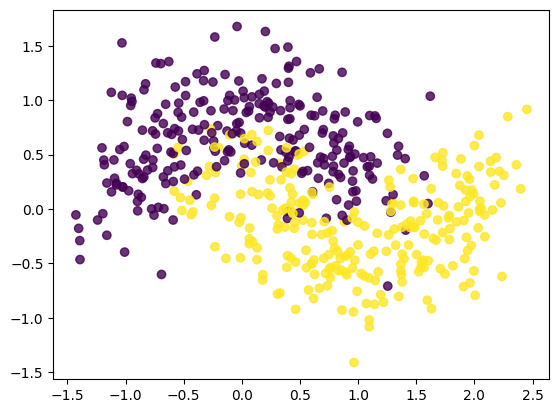

In [20]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=0)
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 1. Voting Classifier

C'est l'ensemble learning le plus simple, on entraine plusieurs modèles, et le meilleur est retenu sous forme de vote.

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

Pour le votingRegressor, cela fait la moyenne des 3 modèles, par exemple, concerant le prix d'un appartement.

Pour votingClassifier, vote hard consiste a prendre la prédiction majoritaire, vote soft, on accumule les probabilités de chaque probabilités (cumule de chaque probablités pour choisir).

Le vote soft est meilleure pour les données bien qualibrés quand c'est possible.

In [12]:
model_1 = SGDClassifier(random_state=0)
model_2 = DecisionTreeClassifier(random_state=0)
model_3 = KNeighborsClassifier(n_neighbors=2)

model_4 = VotingClassifier([('SGD', model_1),
                            ('Tree', model_2),
                            ('KNN', model_3)],
                          voting='hard')

for model in (model_1, model_2, model_3, model_4):
    model.fit(X_train, y_train)
    print(model.__class__.__name__, model.score(X_test, y_test))

SGDClassifier 0.84
DecisionTreeClassifier 0.86
KNeighborsClassifier 0.86
VotingClassifier 0.8733333333333333


Mais la technique de voting n'est pas ouf, le critère de diversité n'est jamais réellement efficace car le criète de diversité de Wisdom of the crown n'est pas respecté.

## 2. Bagging

On utilise ce modèle quand nos modèles singuliers ont tendance à faire de l'overfitting.

In [13]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

Cela cosisite à créer plusieurs copies d'un dataset en entrainant chaque copie sur une parti aléatoire (Bootstrapping).
Cela fait que les modèles n'ont pas été entrainé sur les même données, donc, les modèles auront des points communs mais des résultats différents concernant la prédiction.

En somme, il suffira de prendre les pourcentages les plus élévés des prédictions de modèles pour obtenir y_hat de l'ensemble des modèles.

Les modèles sont entrainé en parrallèle. Chaque modèle est en cas d'over-fitting, les rassemblés permet de réduire la variance des modèles.

RandomForsest est souvent utiliser pour le bagging.

In [22]:
model = BaggingClassifier(estimator=KNeighborsClassifier(),
                         n_estimators=100)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.88

Meilleur que le voting car on arrive à créer de la diversité.

L'argument max_depth est ce qui permet d'optimier le modèle mais attention, si on l'augmente, on s'expose à l'overfitting, donc, il faudra augmenter le n_estimator (mais rallonge l'entrainement).

En général un RandomForestClassifier va avoir de meilleurs résultats qu'un BaggingClassifier avec un KNeighborsClassifier.

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=100) # max_depth facultatif

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.88

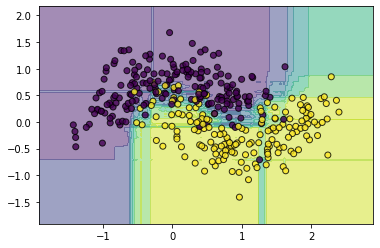

In [65]:
plot_decision_boundary(model, X_train, y_train)

## 3. Boosting

On utilise ce modèle quand nos modèles singuliers ont tendance à faire de l'underfitting.

In [24]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

Le boosting consiste à entrainer un faible premier modèle et de donner les résultats au second modèle (l'un après l'autre) en lui demandant de corriger ces erreures. Philosophiquement, cela revient à dire de compenser les faiblesses des uns par les forces de l'autre. Les modèles sont entrainés en série. Les modèles, unitérement, sont en under-fitting, la combinaison fait qu'on réussira à réduire le biais (bien suivre la forme de la courbe) du modèle.

AdaBoost et GradientBoosting sont souvent utiliser pour le boosting.

In [25]:
model = AdaBoostClassifier(n_estimators=100)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8733333333333333

Ici, on peut utiliser d'autre hyperparamètre comme un estimateur autre que l'arbre de décision, on peut régler le learning rate. Meilleur moyen est d'utiliser une grid search cv.

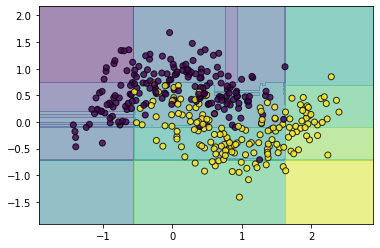

In [57]:
plot_decision_boundary(model, X_train, y_train)

## 4. Stacking

Très utile quand on a passé du temps à entrainer chaque modèle individuellement.

In [0]:
from sklearn.ensemble import StackingClassifier

Cela consisite à rassembler les prédictions de chaque modèles, on demande au deriner estimateur d'apprendre à prédire le résultat final en fonction des prédictions précédentes.

On va reprendre notre voting est appliqué cette méthode pour déterminer l'estimateur.

In [37]:
model = StackingClassifier([('SGD', model_1),
                            ('Tree', model_2),
                            ('KNN', model_3)],
                             final_estimator=KNeighborsClassifier())

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8666666666666667

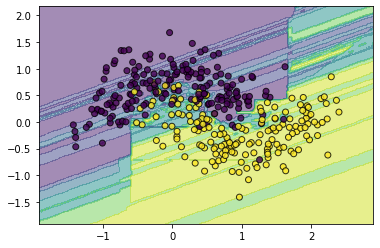

In [38]:
plot_decision_boundary(model, X_train, y_train)